In [11]:
import os, sys
from pathlib import Path

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [14]:
import pixelator
from pixelator import read

In [15]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from pixelator import read, simple_aggregate
import seaborn as sns

In [16]:
import plotly.graph_objects as go
import plotly.io as pio

# Pixelgen data analysis

In [17]:
import networkx as nx 
import itertools 
import scipy 
from py_sphere import voronoi_utility

def create_network(cartesian_coord_array, attributes, t=1, scale=0.2):   
    # Get 3D spheric delaunay triangulization 
    voronoi_instance = voronoi_utility.Voronoi_Sphere_Surface(cartesian_coord_array)
    Delaunay_point_array = voronoi_instance.delaunay_triangulation_spherical_surface()

    # Create network 
    G = nx.Graph()

    all_labels = []
    map_d = dict(zip([tuple(c) for c in cartesian_coord_array], range(len(cartesian_coord_array))))
    for coords in Delaunay_point_array:
        labels = []
        for coord in coords:
            labels.append(map_d[tuple(coord)])

        G.add_nodes_from(labels)
        edges = list(itertools.combinations(labels, 2))
        G.add_edges_from(edges)
        all_labels.append(labels)
    
    # Verify length match between the two
    # assert len(cartesian_coord_array) == len(np.unique(np.hstack(all_labels))
    assert (np.array([map_d[tuple(c)] for c in cartesian_coord_array]) == range(len(cartesian_coord_array))).all()
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(cartesian_coord_array, cartesian_coord_array)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(G.edges()).copy() # Only keep delaunay edges
    nx.set_node_attributes(g, dict(zip(g.nodes(), attributes)), "labels")
    nx.set_node_attributes(g, dict(zip(g.nodes(), cartesian_coord_array)), "pos")
    return g

In [18]:
from pathlib import Path

DATA_DIR = Path.cwd().parents[0] / "data" / 'pixelgen' / 'raw'
data_files = [
    DATA_DIR / "Sample03_Raji_control.dataset.pxl",
    DATA_DIR / "Sample04_Raji_Rituximab_treated.dataset.pxl",
]
data_files = [
    DATA_DIR / "Uropod_control.dataset.pxl",
    DATA_DIR / "Uropod_CD54_fixed_RANTES_stimulated.dataset.pxl",
]

In [19]:
pg_data_combined = simple_aggregate(
    ["Control", "Stimulated"], [read(path) for path in data_files]
)

components_to_keep = pg_data_combined.adata[
    (pg_data_combined.adata.obs["edges"] >= 8000)
    & (pg_data_combined.adata.obs["tau_type"] == "normal")
].obs.index

pg_data_combined = pg_data_combined.filter(
    components=components_to_keep
)

polarity_scores = pg_data_combined.polarization
colocalization_scores = pg_data_combined.colocalization
edgelist = pg_data_combined.edgelist

In [20]:
pg_data_combined.adata.obs['sample'].value_counts()

Control       457
Stimulated    328
Name: sample, dtype: int64

In [21]:
for row in pg_data_combined.adata.obs.itertuples():
    # Get component name
    component = row.Index

    graph = pg_data_combined.graph(component,
                                add_node_marker_counts=True,
                                simplify=True,
                                use_full_bipartite=True)
    graph_layout_data = graph.layout_coordinates("fruchterman_reingold_3d",
                                                only_keep_a_pixels=True,
                                                get_node_marker_matrix=True, )
    break

In [192]:
pg_data_combined.adata.obs

,vertices,edges,antibodies,upia,upib,umi,reads,mean_reads,median_reads,mean_upia_degree,median_upia_degree,mean_umi_per_upia,median_umi_per_upia,umi_per_upia,upia_per_upib,leiden,tau_type,tau,sample
component,,,,,,,,,,,,,,,,,,,
RCVCMP0000000_Control,1892,11229,70,1200,692,11164,105275,9.375278,8.0,3.013333,2.0,9.357500,4.0,9.303333,1.734104,0,normal,0.930828,Control
RCVCMP0000001_Control,4479,23590,79,2858,1621,23297,219124,9.288851,8.0,2.988453,2.0,8.254024,3.0,8.151505,1.763109,6,normal,0.943504,Control
RCVCMP0000002_Control,4281,26012,76,2940,1341,25674,234831,9.027795,8.0,2.637415,1.0,8.847619,3.0,8.732653,2.192394,4,normal,0.964513,Control
RCVCMP0000003_Control,9316,54056,79,6273,3043,52528,465348,8.608628,8.0,2.379085,1.0,8.617249,3.0,8.373665,2.061453,7,normal,0.963378,Control
RCVCMP0000004_Control,2380,11640,70,1671,709,11562,104602,8.986426,8.0,2.674446,2.0,6.965889,3.0,6.919210,2.356841,0,normal,0.939061,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCVCMP0001613_Stimulated,1676,8562,74,1194,482,8528,73012,8.527447,8.0,2.659129,2.0,7.170854,4.0,7.142379,2.477178,3,normal,0.954979,Stimulated
RCVCMP0001656_Stimulated,3043,19697,76,2091,952,19459,165383,8.396355,8.0,2.966045,2.0,9.419895,4.0,9.306074,2.196429,9,normal,0.955876,Stimulated
RCVCMP0001710_Stimulated,1635,9980,72,1111,524,9945,87317,8.749198,8.0,2.769577,2.0,8.982898,4.0,8.951395,2.120229,8,normal,0.970166,Stimulated


In [250]:
row = pg_data_combined.adata.obs.iloc[-1]

# Get component name
component = row.name

graph = pg_data_combined.graph(component,
                            add_node_marker_counts=True,
                            simplify=True,
                            use_full_bipartite=True)
graph_layout_data = graph.layout_coordinates("fruchterman_reingold_3d",
                                            only_keep_a_pixels=True,
                                            get_node_marker_matrix=True, )

In [251]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=graph_layout_data["x"],
            y=graph_layout_data["y"],
            z=graph_layout_data["z"],
            mode="markers",
            marker=dict(size=3, opacity=0.4, colorscale="bluered"),
            marker_color=graph_layout_data["CD50"],
        ),
    ]
)
fig.update_layout(title=component)
fig.show()

In [252]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=graph_layout_data["x_norm"],
            y=graph_layout_data["y_norm"],
            z=graph_layout_data["z_norm"],
            mode="markers",
            marker=dict(size=3, opacity=0.4, colorscale="bluered"),
            marker_color=graph_layout_data["CD50"],
        ),
    ]
)
fig.update_layout(title=component)
fig.show()

In [253]:
cartesian_coord_array = graph_layout_data[['x_norm', 'y_norm', 'z_norm']].values
attributes = graph_layout_data.iloc[:, 6:]


In [254]:
G = create_network(cartesian_coord_array, attributes.values, t=1, scale=0.2)

In [255]:
plt.style.use('dark_background')

def plot_PPI_3D_cmap(network, c=None, lw=1, size=50, cmap='jet'):
    # Get position dict
    pos_dict = nx.get_node_attributes(network, 'pos')
    pos_T = {k: v[[1,0,2]] for k,v in pos_dict.items()}
    # Get position array
    pos = np.array(list(pos_T.values()))
    # Get node and edge location
    node_xyz = np.array([pos_T[v] for v in sorted(network)])
    edge_xyz = np.array([(pos_T[u], pos_T[v]) for u, v in network.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection="3d")

    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color='w', lw=lw)
    ax.scatter(*node_xyz.T, s=50, c=c, cmap=cmap)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    return fig, ax

plt.style.use('dark_background')

def plot_PPI_3D(network):
    # Get position dict
    pos_dict = nx.get_node_attributes(network, 'pos')
    pos_T = {k: v[[1,0,2]] for k,v in pos_dict.items()}
    # Get position array
    pos = np.array(list(pos_T.values()))
    # Get node and edge location
    node_xyz = np.array([pos_T[v] for v in sorted(network)]) 
    edge_xyz = np.array([(pos_T[u], pos_T[v]) for u, v in network.edges()])
    # Create the 3D figure
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection="3d")

    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color='w', lw=1)
    ax.scatter(*node_xyz.T, s=10, color='red')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    return fig, ax

In [256]:
attributes.sum(axis=0).sort_values(ascending=False).head(10)

HLA-ABC    3779
B2M        1381
CD2        1134
CD45       1058
CD3E        905
CD38        883
CD44        568
CD26        428
CD18        242
CD7         228
dtype: int64

In [257]:
rect_shape = [2.2, 2.2, 2.2]

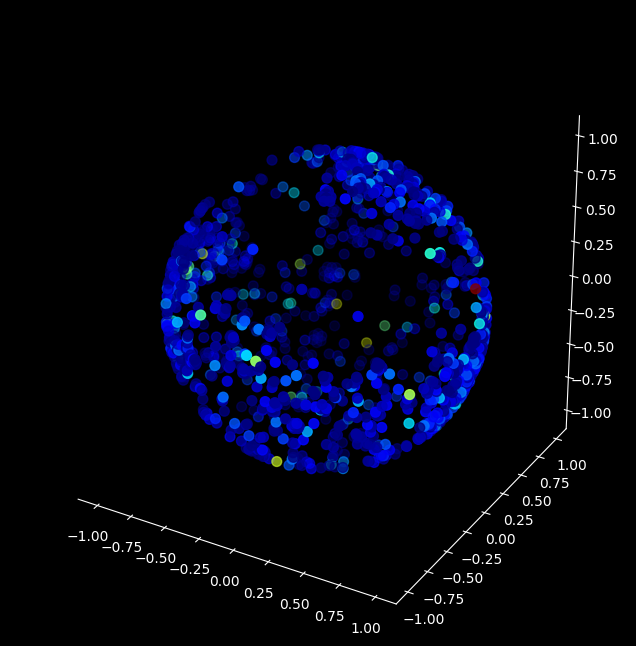

In [258]:
fig, ax = plot_PPI_3D_cmap(G, c=attributes['HLA-ABC'], lw=0, size=50)

# # plot 3D box
# # Prepare lines for the various boxes to be plotted
# verts = np.array([[i, j, k] for i in [0, 1]
#                   for j in [0, 1] for k in [0, 1]]).astype(np.float32)
# lines = [np.array([i, j]) for i in verts
#          for j in verts if np.allclose(np.linalg.norm(i - j), 1)]

# for line in lines:
#     ax.plot((line * rect_shape)[:, 0] - 1.1,
#             (line * rect_shape)[:, 1] - 1.1,
#             (line * rect_shape)[:, 2] - 1.1,
#             linewidth=2, color='w', alpha=0.8,zorder=10)
ax.set_aspect('equal')

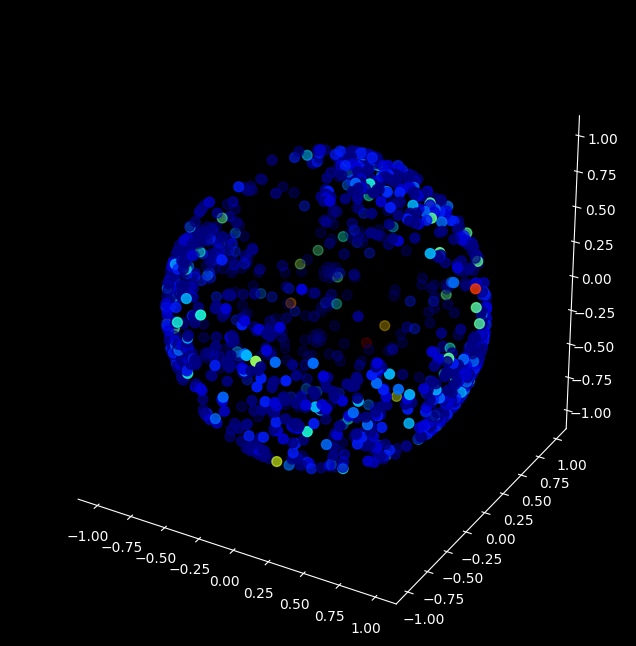

In [259]:
fig, ax = plot_PPI_3D_cmap(G, c=attributes['CD45'], lw=0, size=50)

# # plot 3D box
# # Prepare lines for the various boxes to be plotted
# verts = np.array([[i, j, k] for i in [0, 1]
#                   for j in [0, 1] for k in [0, 1]]).astype(np.float32)
# lines = [np.array([i, j]) for i in verts
#          for j in verts if np.allclose(np.linalg.norm(i - j), 1)]

# for line in lines:
#     ax.plot((line * rect_shape)[:, 0] - 1.1,
#             (line * rect_shape)[:, 1] - 1.1,
#             (line * rect_shape)[:, 2] - 1.1,
#             linewidth=2, color='w', alpha=0.8,zorder=10)
ax.set_aspect('equal')

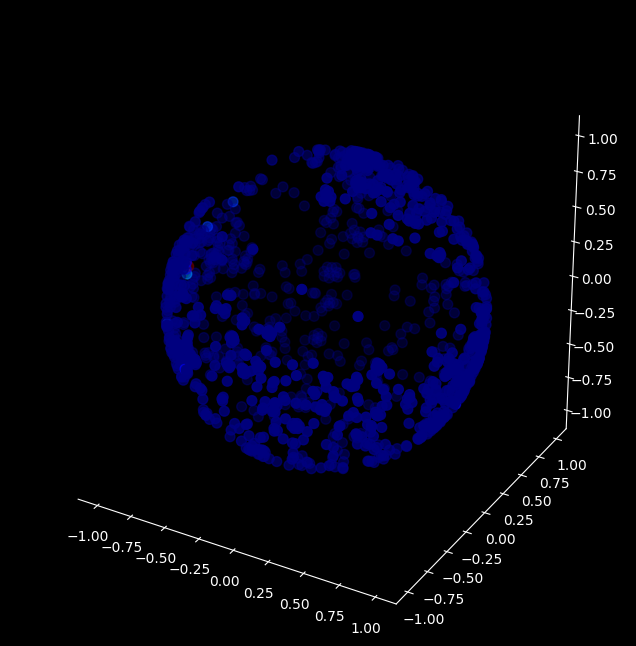

In [260]:
fig, ax = plot_PPI_3D_cmap(G, c=attributes['CD8'], lw=0, size=50)

# # plot 3D box
# # Prepare lines for the various boxes to be plotted
# verts = np.array([[i, j, k] for i in [0, 1]
#                   for j in [0, 1] for k in [0, 1]]).astype(np.float32)
# lines = [np.array([i, j]) for i in verts
#          for j in verts if np.allclose(np.linalg.norm(i - j), 1)]

# for line in lines:
#     ax.plot((line * rect_shape)[:, 0] - 1.1,
#             (line * rect_shape)[:, 1] - 1.1,
#             (line * rect_shape)[:, 2] - 1.1,
#             linewidth=2, color='w', alpha=0.8,zorder=10)
ax.set_aspect('equal')

In [261]:
# fig, ax = plot_PPI_3D_cmap(G, c=attributes['B2M'], lw=0, size=50)

# # # plot 3D box
# # # Prepare lines for the various boxes to be plotted
# # verts = np.array([[i, j, k] for i in [0, 1]
# #                   for j in [0, 1] for k in [0, 1]]).astype(np.float32)
# # lines = [np.array([i, j]) for i in verts
# #          for j in verts if np.allclose(np.linalg.norm(i - j), 1)]

# # for line in lines:
# #     ax.plot((line * rect_shape)[:, 0] - 1.1,
# #             (line * rect_shape)[:, 1] - 1.1,
# #             (line * rect_shape)[:, 2] - 1.1,
# #             linewidth=2, color='w', alpha=0.8,zorder=10)
# ax.set_aspect('equal')

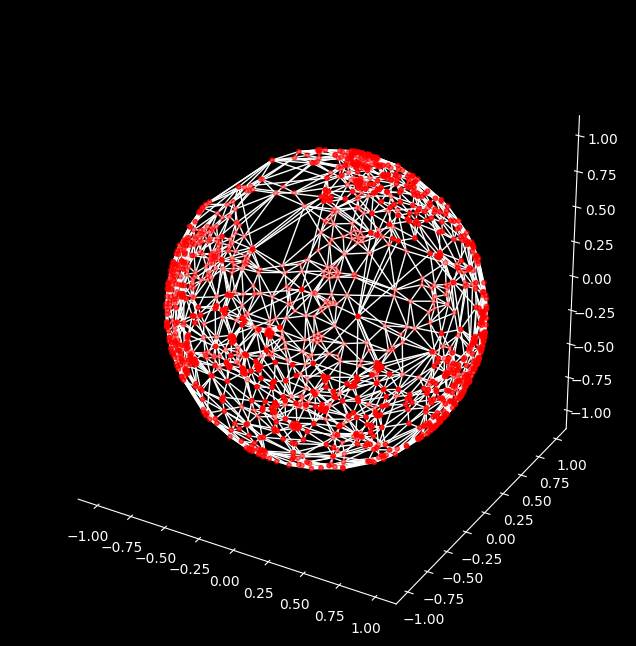

In [262]:
fig, ax = plot_PPI_3D(G)

ax.set_aspect('equal')

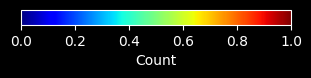

In [263]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(3, 1))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Count')